In [1]:
import pandas as pd

In [2]:
BATCH_SIZE = 100
HIDDEN_SIZE = 32
EMBEDDING_LEN = 300
EPOCH = 1500

In [3]:
accepted = pd.read_excel('ICLR_accepted.xlsx', index_col=[0])
rejected = pd.read_excel('ICLR_rejected.xlsx', index_col=[0])
accepted.rename({0: 'name'}, axis = 1, inplace=True)
rejected.rename({0: 'name'}, axis = 1, inplace=True)
accepted['label'] = 1
rejected['label'] = 0

df_train = pd.concat([accepted[50:], rejected[50:]]).reset_index().drop('index', axis=1)
df_test = pd.concat([accepted[:50], rejected[:50]]).reset_index().drop('index', axis=1)

print(df_train)
print(df_test)

df_train.to_csv('ICLR_train.csv', encoding='utf-8')
df_test.to_csv('ICLR_test.csv', encoding='utf-8')

                                                   name  label
0     Unsupervised Representation Learning by Predic...      1
1     Emergent Communication in a Multi-Modal, Multi...      1
2     FastGCN: Fast Learning with Graph Convolutiona...      1
3     Emergent Translation in Multi-Agent Communication      1
4     An efficient framework for learning sentence r...      1
5     NerveNet: Learning Structured Policy with Grap...      1
6     Learning Latent Representations in Neural Netw...      1
7                    Adversarial Dropout Regularization      1
8                                 Demystifying MMD GANs      1
9     Smooth Loss Functions for Deep Top-k Classific...      1
10    Deep Learning as a Mixed Convex-Combinatorial ...      1
11    Learning Approximate Inference Networks for St...      1
12    LEARNING TO SHARE: SIMULTANEOUS PARAMETER TYIN...      1
13    Model compression via distillation and quantiz...      1
14    Variational Message Passing with Structured In...

In [4]:
def split_text_only(text):
    return "".join((char if char.isalpha() else " ") for char in text).split()

In [5]:
import torch
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
from torchtext.data import TabularDataset

In [6]:
tokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=10)
LABEL = data.LabelField()
trn_datafields = [("id", None),
                    ("name", TEXT),
                    ("label", LABEL)]

train_data = TabularDataset(
               path="./ICLR_train.csv",
               format='csv',
               skip_header=True,
               fields=trn_datafields)

tst_datafields = [("id", None), 
                 ("name", TEXT),
                 ("label", LABEL)]

test_data = TabularDataset(path = "./ICLR_test.csv",
                    format='csv',
                    skip_header=True,
                    fields=tst_datafields)
#train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=EMBEDDING_LEN))
LABEL.build_vocab(train_data)

word_embeddings = TEXT.vocab.vectors
print ("Length of Text Vocabulary: " + str(len(TEXT.vocab)))
print ("Vector size of Text Vocabulary: ", TEXT.vocab.vectors.size())
print ("Label Length: " + str(len(LABEL.vocab)))

train_iter = data.BucketIterator(train_data, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)
test_iter = data.BucketIterator(test_data, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), repeat=False, shuffle=False)

print(next(iter(train_iter)).name)
vocab_size = len(TEXT.vocab)

Length of Text Vocabulary: 2422
Vector size of Text Vocabulary:  torch.Size([2422, 300])
Label Length: 2
(tensor([[  34,   60,    8,   78,   67,    2,  719,    3,    1,    1],
        [1336,  420,   21,  762,    7, 2347,   42,    1,    1,    1],
        [   3,  338,   28,    8, 1922, 1194,    1,    1,    1,    1],
        [2343,  131,   26, 1978,    1,    1,    1,    1,    1,    1],
        [   3,  273,   25, 1918,    1,    1,    1,    1,    1,    1],
        [   3,   13, 1296, 2077,    7,  128,   13,  946, 1732,    2],
        [2258,  179,   19,    1,    1,    1,    1,    1,    1,    1],
        [ 101,  187, 1758,  109,    3,    7, 1771,    1,    1,    1],
        [1587,  126,    3,    2,  307,  230,   11, 1639,    8,   32],
        [   3,  693,   84,    7,   14,  123,    2,  347, 1531,    1],
        [ 324,    8, 1645,  146,   25,  794,  171,    7,  294,    9],
        [  68,  449,   11, 1668, 2113,    1,    1,    1,    1,    1],
        [1042, 1495,   46,    2,   18,    5,    4,    

In [7]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, output_size, hidden_size, vocab_size, embedding_length, weights):
        super(LSTM, self).__init__()
        
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False)
        
        self.lstm = nn.LSTM(embedding_length, hidden_size, num_layers=10, bidirectional=True)
        
        self.label = nn.Linear(20*hidden_size, output_size)

    def forward(self, input_sentences, batch_size=None):    
        input = self.word_embeddings(input_sentences)
        input = input.permute(1, 0, 2)
        h_0 = torch.zeros(20, input_sentences.size()[0], self.hidden_size).cuda()
        c_0 = torch.zeros(20, input_sentences.size()[0], self.hidden_size).cuda()
        output, (h_n, c_n) = self.lstm(input, (h_0, c_0))

        h_n = h_n.permute(1, 0, 2)
        h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
        logits = self.label(h_n)
        
        return logits

net = LSTM(2, HIDDEN_SIZE, vocab_size, EMBEDDING_LEN, word_embeddings)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00005, betas=(0.9, 0.999))

In [9]:
def train_model(train_iter, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    net.cuda()
    steps = 0
    net.train()
    for idx, batch in enumerate(train_iter):
        text = batch.name[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        prediction = net(text)
        loss = criterion(prediction, target)
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        optimizer.step()
        steps += 1
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

In [10]:
def eval_model(val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    net.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.name[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = net(text)
            loss = criterion(prediction, target)
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)

In [11]:
loss_value = []
train_accuracy = []
test_accuracy = []

for epoch in range(EPOCH):  # loop over the dataset multiple times

    train_loss, train_acc = train_model(train_iter, epoch)
    _, val_acc = eval_model(train_iter)
    _, test_acc = eval_model(test_iter)
    
    loss_value.append(train_loss)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print('Epoch', epoch, 'with loss of', train_loss, 'training acc of', train_acc, 'testing acc of', test_acc)

print('Finished Training')

Epoch 0 with loss of 0.6883288942850553 training acc of 57.12087895320012 testing acc of 50.0
Epoch 1 with loss of 0.6856632782862737 training acc of 56.93406589214619 testing acc of 50.0
Epoch 2 with loss of 0.6832753007228558 training acc of 57.07692307692308 testing acc of 50.0
Epoch 3 with loss of 0.6820107560891372 training acc of 57.21978026169997 testing acc of 50.0
Epoch 4 with loss of 0.6811694411131052 training acc of 57.36263744647686 testing acc of 50.0
Epoch 5 with loss of 0.6831943897100595 training acc of 56.505494631253754 testing acc of 50.0
Epoch 6 with loss of 0.6829040279755225 training acc of 56.505494631253754 testing acc of 50.0
Epoch 7 with loss of 0.6813893547424903 training acc of 56.93406589214619 testing acc of 50.0
Epoch 8 with loss of 0.6807663257305439 training acc of 57.07692307692308 testing acc of 50.0
Epoch 9 with loss of 0.6800905741178073 training acc of 57.21978026169997 testing acc of 50.0
Epoch 10 with loss of 0.6794695533238925 training acc of 5

Epoch 87 with loss of 0.41694714243595415 training acc of 80.78022003173828 testing acc of 57.0
Epoch 88 with loss of 0.3984848994475145 training acc of 82.73626356858473 testing acc of 60.0
Epoch 89 with loss of 0.38690961324251616 training acc of 84.03296720064603 testing acc of 58.0
Epoch 90 with loss of 0.38709385578448957 training acc of 84.0989010150616 testing acc of 57.0
Epoch 91 with loss of 0.3690621279753171 training acc of 84.5054943378155 testing acc of 57.0
Epoch 92 with loss of 0.3622370476906116 training acc of 85.68131842980019 testing acc of 56.0
Epoch 93 with loss of 0.343448573580155 training acc of 86.6043953528771 testing acc of 57.0
Epoch 94 with loss of 0.34663459887871373 training acc of 86.52747227595403 testing acc of 55.0
Epoch 95 with loss of 0.3204261064529419 training acc of 88.0989010150616 testing acc of 57.0
Epoch 96 with loss of 0.3107877946816958 training acc of 88.57142873910757 testing acc of 56.0
Epoch 97 with loss of 0.29664454322594863 training 

Epoch 173 with loss of 0.09641509445813987 training acc of 97.62637387789212 testing acc of 55.0
Epoch 174 with loss of 0.09458759856911805 training acc of 97.78022003173828 testing acc of 56.0
Epoch 175 with loss of 0.08861389197409153 training acc of 97.92307692307692 testing acc of 56.0
Epoch 176 with loss of 0.0942507553845644 training acc of 97.62637387789212 testing acc of 58.0
Epoch 177 with loss of 0.09262148620417485 training acc of 97.61538461538461 testing acc of 56.0
Epoch 178 with loss of 0.09421760101731007 training acc of 97.7032969548152 testing acc of 56.0
Epoch 179 with loss of 0.10975637487494029 training acc of 97.01098926250751 testing acc of 56.0
Epoch 180 with loss of 0.10787711937267047 training acc of 97.34065950833835 testing acc of 58.0
Epoch 181 with loss of 0.09057203064171168 training acc of 97.6923076923077 testing acc of 56.0
Epoch 182 with loss of 0.09296266963848701 training acc of 97.7032969548152 testing acc of 56.0
Epoch 183 with loss of 0.104062993

Epoch 259 with loss of 0.06840534837773213 training acc of 98.24175849327675 testing acc of 56.0
Epoch 260 with loss of 0.06544812503629006 training acc of 98.31868157019981 testing acc of 57.0
Epoch 261 with loss of 0.06439357788230364 training acc of 98.47252772404597 testing acc of 57.0
Epoch 262 with loss of 0.06509204022586346 training acc of 98.3956046471229 testing acc of 58.0
Epoch 263 with loss of 0.06412443704903126 training acc of 98.3956046471229 testing acc of 54.0
Epoch 264 with loss of 0.06598654367889349 training acc of 98.16483541635367 testing acc of 59.0
Epoch 265 with loss of 0.07665742432268766 training acc of 97.92307692307692 testing acc of 59.0
Epoch 266 with loss of 0.07704077001947623 training acc of 97.71428563044621 testing acc of 55.0
Epoch 267 with loss of 0.059353580411810145 training acc of 98.53846153846153 testing acc of 60.0
Epoch 268 with loss of 0.0616643105705197 training acc of 98.47252772404597 testing acc of 55.0
Epoch 269 with loss of 0.0614976

Epoch 345 with loss of 0.03720110278719893 training acc of 99.0 testing acc of 56.0
Epoch 346 with loss of 0.037576193240686104 training acc of 99.15384615384616 testing acc of 56.0
Epoch 347 with loss of 0.038829833949701145 training acc of 99.01098926250751 testing acc of 54.0
Epoch 348 with loss of 0.03767031334483853 training acc of 99.0 testing acc of 56.0
Epoch 349 with loss of 0.03717079404025124 training acc of 99.15384615384616 testing acc of 58.0
Epoch 350 with loss of 0.03884756744194489 training acc of 99.0 testing acc of 54.0
Epoch 351 with loss of 0.037455748981581286 training acc of 99.07692307692308 testing acc of 56.0
Epoch 352 with loss of 0.03743913031827945 training acc of 99.15384615384616 testing acc of 56.0
Epoch 353 with loss of 0.037034482086220614 training acc of 99.15384615384616 testing acc of 54.0
Epoch 354 with loss of 0.03663887642323971 training acc of 99.15384615384616 testing acc of 58.0
Epoch 355 with loss of 0.036232065266141526 training acc of 99.15

Epoch 430 with loss of 0.032352433181726016 training acc of 99.15384615384616 testing acc of 57.0
Epoch 431 with loss of 0.0326321146164376 training acc of 99.15384615384616 testing acc of 57.0
Epoch 432 with loss of 0.03238907033720842 training acc of 99.15384615384616 testing acc of 57.0
Epoch 433 with loss of 0.033323044082722984 training acc of 99.07692307692308 testing acc of 57.0
Epoch 434 with loss of 0.032654388037581854 training acc of 99.07692307692308 testing acc of 58.0
Epoch 435 with loss of 0.031685917566602044 training acc of 99.15384615384616 testing acc of 57.0
Epoch 436 with loss of 0.03264201511270725 training acc of 99.15384615384616 testing acc of 57.0
Epoch 437 with loss of 0.037024607380422264 training acc of 99.01098926250751 testing acc of 56.0
Epoch 438 with loss of 0.032326920387836605 training acc of 99.07692307692308 testing acc of 57.0
Epoch 439 with loss of 0.032027237045650296 training acc of 99.15384615384616 testing acc of 57.0
Epoch 440 with loss of 0

Epoch 516 with loss of 0.051095911946434244 training acc of 98.07692307692308 testing acc of 56.0
Epoch 517 with loss of 0.04248158490428558 training acc of 98.61538461538461 testing acc of 56.0
Epoch 518 with loss of 0.03526501149798815 training acc of 99.07692307692308 testing acc of 57.0
Epoch 519 with loss of 0.029387642772724994 training acc of 99.0 testing acc of 57.0
Epoch 520 with loss of 0.028577887882980015 training acc of 99.01098926250751 testing acc of 55.0
Epoch 521 with loss of 0.026894914237065956 training acc of 99.15384615384616 testing acc of 58.0
Epoch 522 with loss of 0.02610813915872803 training acc of 99.15384615384616 testing acc of 57.0
Epoch 523 with loss of 0.025178599207160566 training acc of 99.15384615384616 testing acc of 58.0
Epoch 524 with loss of 0.02485732239885972 training acc of 99.15384615384616 testing acc of 57.0
Epoch 525 with loss of 0.024246074689122345 training acc of 99.15384615384616 testing acc of 59.0
Epoch 526 with loss of 0.023648673972

Epoch 601 with loss of 0.016245593039247278 training acc of 99.23076923076923 testing acc of 58.0
Epoch 602 with loss of 0.0217266665914884 training acc of 99.02197793813852 testing acc of 58.0
Epoch 603 with loss of 0.015834772780251045 training acc of 99.23076923076923 testing acc of 61.0
Epoch 604 with loss of 0.015208420392949708 training acc of 99.3076923076923 testing acc of 58.0
Epoch 605 with loss of 0.015024878657781161 training acc of 99.38461538461539 testing acc of 59.0
Epoch 606 with loss of 0.015835106542978723 training acc of 99.3076923076923 testing acc of 60.0
Epoch 607 with loss of 0.015627054994603477 training acc of 99.3076923076923 testing acc of 58.0
Epoch 608 with loss of 0.016248430142205998 training acc of 99.24175849327675 testing acc of 58.0
Epoch 609 with loss of 0.015777138482707623 training acc of 99.38461538461539 testing acc of 58.0
Epoch 610 with loss of 0.015141560330028789 training acc of 99.23076923076923 testing acc of 59.0
Epoch 611 with loss of 0.

Epoch 685 with loss of 0.011207272345647933 training acc of 99.6923076923077 testing acc of 58.0
Epoch 686 with loss of 0.011487948312815906 training acc of 99.53846153846153 testing acc of 58.0
Epoch 687 with loss of 0.01113448040604663 training acc of 99.53846153846153 testing acc of 58.0
Epoch 688 with loss of 0.010868113987761227 training acc of 99.53846153846153 testing acc of 58.0
Epoch 689 with loss of 0.010681094438321171 training acc of 99.61538461538461 testing acc of 58.0
Epoch 690 with loss of 0.010778879347176721 training acc of 99.61538461538461 testing acc of 58.0
Epoch 691 with loss of 0.01160448406321498 training acc of 99.6923076923077 testing acc of 58.0
Epoch 692 with loss of 0.011225955454462495 training acc of 99.76923076923077 testing acc of 59.0
Epoch 693 with loss of 0.010495912041873313 training acc of 99.76923076923077 testing acc of 58.0
Epoch 694 with loss of 0.011500885683255127 training acc of 99.76923076923077 testing acc of 58.0
Epoch 695 with loss of 0

Epoch 770 with loss of 0.0065988379294419875 training acc of 99.76923076923077 testing acc of 55.0
Epoch 771 with loss of 0.00707609410612629 training acc of 99.76923076923077 testing acc of 55.0
Epoch 772 with loss of 0.0072045986638001455 training acc of 99.76923076923077 testing acc of 55.0
Epoch 773 with loss of 0.0068095234685013285 training acc of 99.6923076923077 testing acc of 56.0
Epoch 774 with loss of 0.006731981514559056 training acc of 99.76923076923077 testing acc of 57.0
Epoch 775 with loss of 0.007241130463975983 training acc of 99.76923076923077 testing acc of 57.0
Epoch 776 with loss of 0.0070614299167153565 training acc of 99.6923076923077 testing acc of 57.0
Epoch 777 with loss of 0.008021138038692208 training acc of 99.6923076923077 testing acc of 57.0
Epoch 778 with loss of 0.0067664488630655864 training acc of 99.6923076923077 testing acc of 55.0
Epoch 779 with loss of 0.00782801352705484 training acc of 99.76923076923077 testing acc of 56.0
Epoch 780 with loss o

Epoch 854 with loss of 0.006248742605049091 training acc of 99.76923076923077 testing acc of 56.0
Epoch 855 with loss of 0.007126410947631274 training acc of 99.6923076923077 testing acc of 57.0
Epoch 856 with loss of 0.007230911919088192 training acc of 99.6923076923077 testing acc of 57.0
Epoch 857 with loss of 0.008595490778903835 training acc of 99.54945080096905 testing acc of 58.0
Epoch 858 with loss of 0.009603440047402937 training acc of 99.3956046471229 testing acc of 57.0
Epoch 859 with loss of 0.008775199763476849 training acc of 99.62637387789212 testing acc of 57.0
Epoch 860 with loss of 0.00679638859527096 training acc of 99.76923076923077 testing acc of 57.0
Epoch 861 with loss of 0.006437503070628736 training acc of 99.6923076923077 testing acc of 55.0
Epoch 862 with loss of 0.006949232409869392 training acc of 99.6923076923077 testing acc of 57.0
Epoch 863 with loss of 0.00784510946743047 training acc of 99.61538461538461 testing acc of 57.0
Epoch 864 with loss of 0.00

Epoch 938 with loss of 0.006505093618006168 training acc of 99.76923076923077 testing acc of 57.0
Epoch 939 with loss of 0.007550983007604373 training acc of 99.76923076923077 testing acc of 57.0
Epoch 940 with loss of 0.007128179692349827 training acc of 99.76923076923077 testing acc of 57.0
Epoch 941 with loss of 0.006981221822990427 training acc of 99.61538461538461 testing acc of 56.0
Epoch 942 with loss of 0.007130085322037653 training acc of 99.76923076923077 testing acc of 57.0
Epoch 943 with loss of 0.006769980416160811 training acc of 99.76923076923077 testing acc of 56.0
Epoch 944 with loss of 0.0072974462869192045 training acc of 99.76923076923077 testing acc of 57.0
Epoch 945 with loss of 0.006452003749403117 training acc of 99.76923076923077 testing acc of 57.0
Epoch 946 with loss of 0.006374897674294726 training acc of 99.76923076923077 testing acc of 57.0
Epoch 947 with loss of 0.00686169456009968 training acc of 99.76923076923077 testing acc of 56.0
Epoch 948 with loss 

Epoch 1022 with loss of 0.006408109166211664 training acc of 99.76923076923077 testing acc of 54.0
Epoch 1023 with loss of 0.006837396252824244 training acc of 99.76923076923077 testing acc of 56.0
Epoch 1024 with loss of 0.006401203236936663 training acc of 99.76923076923077 testing acc of 54.0
Epoch 1025 with loss of 0.006384963230839975 training acc of 99.76923076923077 testing acc of 54.0
Epoch 1026 with loss of 0.007946068640124464 training acc of 99.62637387789212 testing acc of 56.0
Epoch 1027 with loss of 0.006608709112557475 training acc of 99.6923076923077 testing acc of 55.0
Epoch 1028 with loss of 0.006175231603405196 training acc of 99.76923076923077 testing acc of 57.0
Epoch 1029 with loss of 0.00811430985833375 training acc of 99.62637387789212 testing acc of 57.0
Epoch 1030 with loss of 0.006423952473806611 training acc of 99.76923076923077 testing acc of 56.0
Epoch 1031 with loss of 0.006278559012431428 training acc of 99.76923076923077 testing acc of 55.0
Epoch 1032 w

Epoch 1105 with loss of 0.006815609996920102 training acc of 99.61538461538461 testing acc of 55.0
Epoch 1106 with loss of 0.0067162629790031 training acc of 99.76923076923077 testing acc of 56.0
Epoch 1107 with loss of 0.0063600785412675645 training acc of 99.76923076923077 testing acc of 55.0
Epoch 1108 with loss of 0.00672690445040084 training acc of 99.6923076923077 testing acc of 55.0
Epoch 1109 with loss of 0.006355702532276224 training acc of 99.76923076923077 testing acc of 56.0
Epoch 1110 with loss of 0.006997665005306212 training acc of 99.76923076923077 testing acc of 55.0
Epoch 1111 with loss of 0.006230375261881049 training acc of 99.76923076923077 testing acc of 56.0
Epoch 1112 with loss of 0.0062491938890441535 training acc of 99.76923076923077 testing acc of 56.0
Epoch 1113 with loss of 0.006573093071403071 training acc of 99.76923076923077 testing acc of 57.0
Epoch 1114 with loss of 0.006362259302057702 training acc of 99.76923076923077 testing acc of 55.0
Epoch 1115 w

Epoch 1188 with loss of 0.006411287602811801 training acc of 99.76923076923077 testing acc of 57.0
Epoch 1189 with loss of 0.006598892175763747 training acc of 99.76923076923077 testing acc of 56.0
Epoch 1190 with loss of 0.011111238188627444 training acc of 99.6923076923077 testing acc of 55.0
Epoch 1191 with loss of 0.21073122610015652 training acc of 96.93406618558444 testing acc of 57.0
Epoch 1192 with loss of 0.25617845055575555 training acc of 93.15384615384616 testing acc of 57.0
Epoch 1193 with loss of 0.13522530175172365 training acc of 93.64835181603065 testing acc of 57.0
Epoch 1194 with loss of 0.05829196036435091 training acc of 98.84615384615384 testing acc of 54.0
Epoch 1195 with loss of 0.04213308019993397 training acc of 98.78022003173828 testing acc of 57.0
Epoch 1196 with loss of 0.029166654074707858 training acc of 99.53846153846153 testing acc of 55.0
Epoch 1197 with loss of 0.022423240105406597 training acc of 99.46153846153847 testing acc of 54.0
Epoch 1198 with 

Epoch 1271 with loss of 0.006375681376644375 training acc of 99.76923076923077 testing acc of 57.0
Epoch 1272 with loss of 0.006322623065968331 training acc of 99.76923076923077 testing acc of 59.0
Epoch 1273 with loss of 0.006408260011364921 training acc of 99.76923076923077 testing acc of 56.0
Epoch 1274 with loss of 0.006499148388684262 training acc of 99.76923076923077 testing acc of 57.0
Epoch 1275 with loss of 0.0063218105354350814 training acc of 99.76923076923077 testing acc of 59.0
Epoch 1276 with loss of 0.006214526269244603 training acc of 99.76923076923077 testing acc of 59.0
Epoch 1277 with loss of 0.0061438299979692185 training acc of 99.76923076923077 testing acc of 58.0
Epoch 1278 with loss of 0.006616374318232724 training acc of 99.76923076923077 testing acc of 58.0
Epoch 1279 with loss of 0.006117036912305944 training acc of 99.76923076923077 testing acc of 58.0
Epoch 1280 with loss of 0.006207794014839097 training acc of 99.76923076923077 testing acc of 58.0
Epoch 12

Epoch 1354 with loss of 0.006602853708430372 training acc of 99.76923076923077 testing acc of 58.0
Epoch 1355 with loss of 0.006692282191719501 training acc of 99.76923076923077 testing acc of 57.0
Epoch 1356 with loss of 0.007918015983495234 training acc of 99.62637387789212 testing acc of 57.0
Epoch 1357 with loss of 0.006794912531264485 training acc of 99.6923076923077 testing acc of 57.0
Epoch 1358 with loss of 0.006532940995384706 training acc of 99.76923076923077 testing acc of 55.0
Epoch 1359 with loss of 0.006377016176534548 training acc of 99.76923076923077 testing acc of 58.0
Epoch 1360 with loss of 0.006276284777413821 training acc of 99.76923076923077 testing acc of 57.0
Epoch 1361 with loss of 0.007222156603417646 training acc of 99.76923076923077 testing acc of 58.0
Epoch 1362 with loss of 0.006347820446675401 training acc of 99.76923076923077 testing acc of 59.0
Epoch 1363 with loss of 0.0062773862888347 training acc of 99.76923076923077 testing acc of 58.0
Epoch 1364 wi

Epoch 1437 with loss of 0.010591451537318509 training acc of 99.62637387789212 testing acc of 55.0
Epoch 1438 with loss of 0.006292102297895606 training acc of 99.76923076923077 testing acc of 56.0
Epoch 1439 with loss of 0.006446184845677076 training acc of 99.76923076923077 testing acc of 58.0
Epoch 1440 with loss of 0.00628164613534374 training acc of 99.76923076923077 testing acc of 58.0
Epoch 1441 with loss of 0.006252444355945604 training acc of 99.76923076923077 testing acc of 58.0
Epoch 1442 with loss of 0.006341324836914562 training acc of 99.76923076923077 testing acc of 56.0
Epoch 1443 with loss of 0.006413981602376085 training acc of 99.76923076923077 testing acc of 57.0
Epoch 1444 with loss of 0.006403472802048782 training acc of 99.76923076923077 testing acc of 57.0
Epoch 1445 with loss of 0.006278478257277479 training acc of 99.76923076923077 testing acc of 56.0
Epoch 1446 with loss of 0.006353032757593051 training acc of 99.76923076923077 testing acc of 58.0
Epoch 1447 

In [12]:
print('Loss value: ', loss_value[-1])
print('Training accuracy: ', train_accuracy[-1])
print('Testing accuracy: ', test_accuracy[-1])

Loss value:  0.006146443769186869
Training accuracy:  99.76923076923077
Testing accuracy:  56.0


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

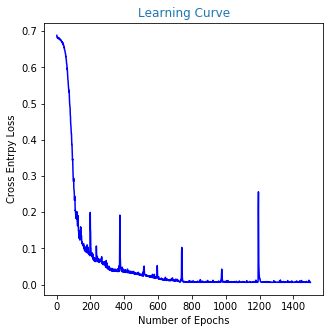

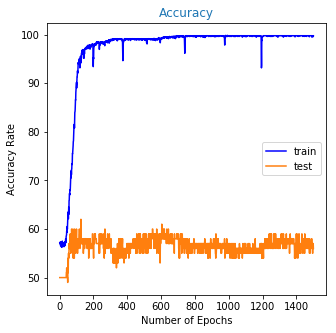

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Learning Curve'.format('default'), color='C0')
ax.set_ylabel('Cross Entrpy Loss')
ax.set_xlabel('Number of Epochs')
ax.plot(list(i+1 for i in range(len(loss_value))), loss_value, 'b')

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Accuracy'.format('default'), color='C0')
ax.set_ylabel('Accuracy Rate')
ax.set_xlabel('Number of Epochs')
ax.plot(list(i+1 for i in range(len(train_accuracy))), train_accuracy, 'b', label='train')
ax.plot(list(i+1 for i in range(len(test_accuracy))), test_accuracy, 'tab:orange', label='test')
ax.legend()